In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing

# 1. Load and Explore the Data

In [16]:
# Load dataset
data = fetch_california_housing()

# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable (house prices)
df['MedHouseVal'] = data.target

# Display the first few rows
print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


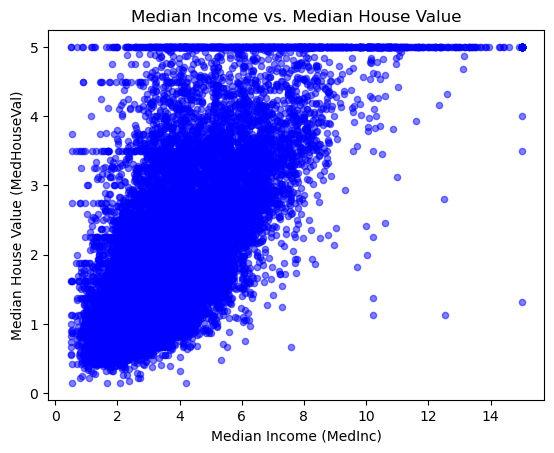

In [3]:
#Scatter Plot
df.plot.scatter(x='MedInc', y='MedHouseVal', alpha=0.5, color='blue')
plt.title("Median Income vs. Median House Value")
plt.xlabel("Median Income (MedInc)")
plt.ylabel("Median House Value (MedHouseVal)")
plt.show()

In [4]:
# Calculate summary statistics
summary_stats = df[['MedInc', 'MedHouseVal']].agg(['mean', 'median', 'std'])

# Display summary statistics
print(summary_stats)

          MedInc  MedHouseVal
mean    3.870671     2.068558
median  3.534800     1.797000
std     1.899822     1.153956


# 2. Preprocess the Data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

In [6]:
# Split data into features (X) and target (y)
X = df.drop(columns=['MedHouseVal'])  # Features
y = df['MedHouseVal']  # Target variable

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# Display dataset shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (16512, 8)
Testing set shape: (4128, 8)


# 3. Build a Linear Regression Model

In [7]:
from sklearn.metrics import mean_squared_error

# Add bias term (column of ones) for intercept
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]


In [8]:
# **Batch Gradient Descent**
def batch_gradient_descent(X, y, alpha=0.01, iterations=500):
    m, n = X.shape
    theta = np.zeros(n)  # Initialize parameters inside function
    for _ in range(iterations):
        gradient = (1/m) * X.T.dot(X.dot(theta) - y)
        theta -= alpha * gradient
    return theta

In [9]:
# **Stochastic Gradient Descent**
def stochastic_gradient_descent(X, y, alpha=0.0001, epochs=1000, tol=1e-6):
    m, n = X.shape
    theta = np.zeros(n)
    prev_loss = float('inf')

    for epoch in range(epochs):
        for i in range(m):
            rand_index = np.random.randint(0, m)
            xi = X[rand_index:rand_index+1]
            yi = y[rand_index:rand_index+1]
            gradient = xi.T.dot(xi.dot(theta) - yi)
            
            # Gradient Clipping
            gradient = np.clip(gradient, -10, 10)
            
            theta -= alpha * gradient  # Update step

        # Compute loss
        loss = mean_squared_error(y, X.dot(theta))

        # Stop if NaN appears
        if np.isnan(loss):
            print("NaN encountered! Reducing learning rate.")
            alpha *= 0.1  # Reduce learning rate
            continue

        # Early stopping
        if abs(prev_loss - loss) < tol:
            print(f"Stopping early at epoch {epoch}")
            break

        prev_loss = loss

    return theta


In [10]:
# Train models
theta_batch = batch_gradient_descent(X_train_scaled, y_train, alpha=0.01, iterations=500)
theta_sgd = stochastic_gradient_descent(X_train_scaled, y_train, alpha=0.005, epochs=1000)

# 4. Make Predictions

In [11]:
# Make predictions
y_pred_batch = X_test_scaled.dot(theta_batch)
y_pred_sgd = X_test_scaled.dot(theta_sgd)

# Evaluate performance using Mean Squared Error (MSE)
mse_batch = mean_squared_error(y_test, y_pred_batch)
mse_sgd = mean_squared_error(y_test, y_pred_sgd)

print("Theta (Batch Gradient Descent):", theta_batch)
print("Theta (Stochastic Gradient Descent):", theta_sgd)
print("MSE (Batch Gradient Descent):", mse_batch)
print("MSE (Stochastic Gradient Descent):", mse_sgd)

Theta (Batch Gradient Descent): [ 2.05833325  0.79130506  0.19523899 -0.02421649  0.03516598  0.01905663
 -0.04460445 -0.32205604 -0.27942375]
Theta (Stochastic Gradient Descent): [ 2.04592146  0.90184472  0.06930998 -0.38534409  0.46571293  0.01177445
 -1.87426113 -0.85070842 -0.80883936]
MSE (Batch Gradient Descent): 0.5960558232007803
MSE (Stochastic Gradient Descent): 0.6162426938077966


In [15]:
# New district with MedInc = 8.0 (other features set to training mean)
new_data = np.array([[8.0] + list(X_train.mean(axis=0)[1:])])  # Keeping other features at mean

# Standardize using the same scaler
new_data_scaled = scaler.transform(new_data)

# Add bias term
new_data_scaled = np.c_[np.ones(new_data_scaled.shape[0]), new_data_scaled]

# Predict house value using both models
pred_batch = new_data_scaled.dot(theta_batch)
pred_sgd = new_data_scaled.dot(theta_sgd)

print("Predicted House Value (Batch GD):", pred_batch[0])
print("Predicted House Value (Stochastic GD):", pred_sgd[0])


Predicted House Value (Batch GD): 3.770085132658928
Predicted House Value (Stochastic GD): 3.9967928466233253


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 5. Visualize the Results

In [18]:
import seaborn as sns

# Sort test data for better visualization
sorted_indices = np.argsort(X_test_scaled[:, 1])  # Sort by MedInc (first feature)
X_sorted = X_test_scaled[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_pred_batch_sorted = y_pred_batch[sorted_indices]
y_pred_sgd_sorted = y_pred_sgd[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[:, 1], y_test, color='blue', label='Actual Data', alpha=0.5)
plt.plot(X_sorted[:, 1], y_pred_batch_sorted, color='red', label='Batch Gradient Descent', linewidth=2)
plt.plot(X_sorted[:, 1], y_pred_sgd_sorted, color='green', linestyle='dashed', label='Stochastic Gradient Descent', linewidth=2)

# Labels and legend
plt.xlabel("MedInc (Standardized)")
plt.ylabel("MedHouseVal")
plt.title("House Price Prediction using Linear Regression")
plt.legend()
plt.show()



KeyError: '[1356, 1649, 3249, 800, 3469, 2528, 1523, 3871, 3521, 2666, 1854, 185, 875, 2844, 632, 1105, 3299, 1138, 1587, 3311, 1517, 3369, 258, 206, 1428, 650, 1961, 311, 3435, 3065, 2031, 2100, 2804, 1673, 1902, 2843, 1581, 338, 895, 2920, 3742, 1490, 1212, 2644, 1400, 1865, 1059, 3741, 3172, 3344, 300, 3096, 846, 68, 352, 2424, 2816, 3706, 2357, 3569, 2547, 1041, 1465, 2807, 1233, 2337, 2284, 1539, 1935, 3281, 97, 1794, 413, 594, 4077, 1343, 2172, 518, 787, 3732, 1651, 297, 1438, 3459, 1932, 3276, 1378, 689, 2750, 163, 1170, 3019, 2391, 2763, 1413, 3988, 1467, 3188, 2911, 3253, 1825, 1384, 1885, 2591, 2018, 4047, 3956, 3116, 3010, 1042, 93, 3267, 3241, 3680, 3590, 3581, 3109, 3639, 1529, 372, 2030, 3363, 529, 3772, 4001, 2038, 3567, 571, 244, 337, 1849, 2313, 1240, 4096, 184, 3358, 3141, 2137, 969, 1887, 3231, 3856, 2465, 1574, 1561, 3430, 3377, 159, 2993, 805, 2867, 2355, 2256, 1043, 1759, 1171, 604, 3240, 1319, 1464, 2803, 479, 3428, 2774, 4082, 3853, 3928, 829, 53, 150, 3290, 3259, 4078, 225, 574, 2695, 2091, 3841, 2890, 1875, 1018, 2374, 30, 469, 1914, 1306, 807, 2846, 1118, 690, 528, 1797, 3799, 1379, 2646, 371, 2428, 3067, 2292, 1801, 3139, 1917, 2509, 3839, 1896, 539, 3658, 1139, 254, 87, 207, 1176, 1830, 1103, 1439, 3042, 126, 2847, 1816, 3880, 772, 1969, 1169, 232, 495, 2599, 2990, 1774, 1884, 1426, 392, 2607, 3712, 1246, 3624, 3166, 2877, 3667, 82, 83, 899, 3193, 2122, 2242, 175, 2024, 3223, 3642, 2593, 2762, 2845, 3088, 1963, 3224, 3112, 1326, 4008, 1496, 2625, 3692, 3745, 3154, 527, 598, 373, 3175, 2058, 939, 174, 3120, 2632, 275, 1791, 2368, 3321, 3782, 1361, 2652, 850, 4070, 1741, 3637, 3594, 3255, 493, 2792, 1234, 307, 3083, 918, 2378, 863, 973, 1025, 1085, 3516, 4116, 1459, 2934, 2108, 666, 2069, 2029, 2732, 903, 1639, 106, 3774, 2359, 1101, 1463, 2203, 1203, 92, 997, 472, 1767, 1305, 3833, 1294, 1058, 3918, 336, 3252, 2983, 3852, 176, 2363, 1792, 634, 915, 1808, 2264, 3911, 1492, 140, 3735, 4114, 158, 1614, 681, 224, 946, 2188, 912, 1540, 1482, 1394, 2328, 2556, 243, 2850, 1436, 3417, 2419, 2628, 2183, 2342, 564, 1407, 1641, 3625, 742, 1992, 3593, 3899, 25, 1133, 865, 1140, 3099, 3731, 2835, 3339, 4099, 350, 879, 1817, 2894, 86, 1174, 1903, 4102, 3173, 3170, 2139, 342, 1820, 2181, 1524, 3547, 145, 4039, 2756, 2459, 1757, 2561, 3205, 1415, 1090, 2592, 2726, 1143, 1154, 1888, 1265, 2060, 925, 1412, 1634, 2200, 2521, 3443, 1324, 3403, 835, 2818, 524, 3232, 2872, 56, 1391, 3796, 1380, 2604, 1180, 477, 3659, 4079, 301, 391, 1941, 3309, 3903, 765, 2772, 3155, 3985, 2649, 2758, 1216, 2011, 388, 1677, 1137, 3449, 2977, 1766, 1876, 1226, 1334, 612, 2311, 3549, 3504, 2158, 1617, 3790, 2888, 1537, 4005, 2429, 974, 1749, 2461, 2381, 2383, 2947, 2318, 1834, 2375, 4004, 811, 4009, 788, 3058, 2088, 2655, 1501, 3389, 3104, 4100, 2618, 1104, 3039, 214, 2280, 148, 3418, 1485, 3777, 1938, 3460, 2316, 219, 519, 3944, 2213, 3160, 1422, 1500, 830, 2491, 3082, 3026, 1079, 905, 1735, 2464, 109, 3664, 2191, 2341, 2819, 1721, 1472, 523, 3636, 3983, 1410, 1645, 3829, 3237, 1586, 164, 4062, 1181, 2365, 3257, 2260, 3040, 2667, 3038, 1856, 3296, 2584, 663, 1827, 3603, 3179, 3531, 3107, 2738, 2463, 3349, 4002, 3209, 1022, 1235, 2817, 1036, 3951, 1099, 147, 3400, 3442, 491, 2679, 2376, 1420, 2054, 773, 2109, 2731, 1411, 235, 1790, 2768, 3584, 378, 1637, 3013, 1366, 2986, 591, 3285, 3726, 3600, 2822, 3857, 306, 2062, 1296, 356, 153, 3868, 732, 2113, 2713, 3217, 1609, 2437, 947, 187, 3526, 3859, 611, 1314, 1956, 3539, 79, 2105, 1447, 2573, 2634, 3904, 4055, 3153, 2230, 2237, 149, 266, 1543, 295, 2565, 1595, 179, 1001, 1596, 1907, 353, 1440, 1964, 2525, 2262, 2905, 1824, 2969, 917, 2970, 1108, 3331, 530, 1652, 609, 405, 3576, 1576, 2813, 3765, 1165, 2019, 923, 639, 2923, 199, 1533, 2164, 468, 1232, 2001, 386, 488, 2057, 3758, 3858, 1623, 858, 2942, 2682, 531, 3697, 3123, 3596, 1050, 3675, 1910, 2611, 4083, 2697, 1451, 3546, 1727, 3952, 1811, 215, 2927, 3761, 3937, 3810, 1053, 2623, 1141, 1967, 3445, 2889, 3920, 3713, 979, 3186, 2102, 3456, 395, 2273, 2169, 216, 2447, 727, 3803, 3446, 953, 3898, 1668, 2055, 1271, 1142, 3575, 653, 2840, 2251, 142, 3555, 1853, 250, 4041, 2523, 2526, 750, 3815, 2500, 1308, 533, 618, 3271, 234, 80, 1083, 403, 1615, 2210, 2572, 2586, 2170, 1550, 3131, 1491, 985, 1929, 2562, 643, 1965, 2543, 1951, 1273, 2335, 2239, 1643, 2648, 2006, 1514, 1653, 2138, 2857, 1200, 256, 988, 2035, 3619, 2297, 3690, 1740, 2722, 2574, 69, 2706, 2396, 892, 1126, 3398, 4011, 3583, 2021, 2435, 1598, 2865, 2784, 2569, 3813, 1893, 304, 3150, 81, 2553, 1062, 1330, 3720, 3357, 1879, 2324, 399, 2193, 4108, 3422, 1723, 1121, 3724, 814, 1048, 761, 1650, 2205, 676, 954, 1958, 590, 1054, 1881, 463, 125, 3960, 3441, 934, 597, 2820, 3557, 1, 2786, 587, 1793, 404, 659, 3408, 1148, 1134, 2083, 3751, 2823, 355, 2689, 10, 294, 4040, 3229, 1479, 1618, 2155, 845, 3647, 2449, 3466, 26, 2409, 2603, 719, 3254, 1051, 1655, 1772, 1509, 3192, 192, 3227, 3845, 143, 2651, 1368, 759, 793, 1620, 1691, 924, 1843, 1717, 3447, 1845, 110, 537, 1416, 1810, 1621, 316, 3744, 3275, 2918, 3054, 4066, 1480, 1381, 1814, 2490, 1955, 3362, 4063, 1076, 1582, 3145, 430, 2253, 3514, 698, 1236, 51, 2952, 3359, 633, 264, 3602, 737, 1732, 1160, 3411, 227, 3760, 1784, 1506, 884, 656, 2854, 1558, 3915, 3716, 578, 1064, 310, 3025, 1015, 1164, 62, 3700, 3862, 325, 801, 557, 498, 2042, 1681, 646, 1403, 3250, 94, 3851, 3086, 2955, 652, 1924, 3450, 3968, 885, 1242, 3092, 1520, 625, 2479, 3837, 3102, 2693, 1536, 2530, 334, 1280, 1359, 1936, 1836, 3149, 1369, 1224, 3574, 393, 1819, 3938, 3746, 3030, 2886, 1633, 776, 2227, 703, 2056, 141, 717, 725, 166, 2902, 269, 948, 3491, 3483, 1546, 1993, 3057, 908, 3243, 3484, 3908, 838, 2123, 700, 1316, 756, 3536, 2248, 2154, 4124, 2838, 429, 3740, 3228, 573, 1945, 39, 1725, 3239, 2688, 1069, 445, 3462, 2833, 1100, 1687, 3022, 420, 1322, 673, 48, 220, 66, 2882, 1680, 610, 3561, 4030, 1195, 2269, 89, 791, 607, 209, 3945, 3614, 1151, 2734, 475, 177, 1777, 2473, 486, 1468, 1192, 760, 1175, 3373, 1466, 3913, 4050, 2567, 3071, 1386, 1351, 3884, 4126, 437, 2398, 2204, 506, 2027, 1882, 1497, 1745, 3244, 3863, 3312, 345, 2456, 3041, 1841, 3676, 1405, 1532, 1155, 1055, 1301, 3708, 2116, 3797, 3464, 2938, 2650, 3762, 4042, 1302, 1446, 2620, 4117, 1132, 886, 1699, 638, 949, 2182, 938, 3994, 2007, 951, 2619, 4091, 2801, 3475, 2853, 1435, 904, 95, 3182, 2004, 593, 195, 559, 1973, 1915, 3881, 2601, 3719, 441, 454, 848, 494, 588, 619, 2508, 3238, 2395, 1724, 654, 12, 2427, 1388, 2377, 1191, 3061, 3413, 556, 3876, 3129, 680, 1285, 2564, 3696, 840, 238, 1696, 3914, 61, 1706, 603, 4067, 704, 4081, 1342, 1198, 2385, 3791, 910, 3580, 500, 535, 722, 1421, 1897, 330, 3611, 1970, 1093, 3982, 280, 2551, 902, 1665, 384, 2469, 728, 1545, 3660, 3802, 1549, 1304, 303, 98, 3161, 1832, 2382, 816, 3005, 283, 63, 1505, 3591, 2901, 747, 1262, 2226, 3940, 2406, 1658, 3409, 1990, 3888, 2314, 2916, 3738, 1812, 3811, 1037, 3221, 3016, 1878, 3004, 1060, 1989, 3995, 1287, 3329, 1622, 2568, 3387, 3773, 453, 2257, 920, 3793, 3630, 11, 4018, 1919, 2949, 2249, 1068, 916, 516, 3756, 2664, 2418, 888, 3198, 3816, 2462, 3783, 2016, 3440, 1414, 167, 3663, 1469, 1124, 124, 3891, 3679, 2156, 1188, 2372, 1458, 45, 1352, 1547, 3436, 1161, 958, 2309, 2691, 2107, 1716, 2468, 739, 784, 1268, 478, 893, 526, 3308, 1363, 896, 2336, 3355, 2612, 2400, 769, 1629, 1511, 2014, 2087, 1954, 2124, 933, 913, 105, 3691, 1179, 489, 329, 100, 2233, 2434, 444, 4071, 197, 3451, 364, 2477, 965, 3286, 171, 3185, 4094, 1483, 1922, 3305, 2532, 959, 3543, 2165, 2160, 419, 2832, 3620, 456, 2023, 3093, 1764, 1702, 1070, 3465, 1799, 38, 1525, 2974, 1074, 1387, 4120, 1636, 2259, 2161, 671, 2520, 3194, 242, 2293, 3764, 3220, 2033, 4080, 932, 168, 3954, 1375, 2744, 1196, 3294, 2989, 1937, 2432, 3897, 3701, 3872, 1519, 978, 3631, 1877, 674, 832, 996, 1771, 3959, 2502, 2451, 3167, 3072, 780, 3327, 1616, 2352, 1189, 1568, 2658, 3565, 3020, 3453, 658, 3924, 331, 3553, 3009, 3512, 3095, 1231, 572, 3626, 3212, 1644, 193, 120, 3685, 2349, 2587, 1597, 1300, 3427, 1694, 3098, 1168, 3006, 282, 3943, 2344, 3831, 3297, 3629, 3158, 151, 1538, 1659, 693, 3021, 2329, 854, 3651, 517, 701, 745, 2379, 1648, 1551, 2631, 1912, 154, 2345, 3074, 2537, 677, 3325, 2354, 2332, 1733, 2788, 3977, 284, 3879, 3477, 2552, 665, 3736, 1982, 3283, 2694, 3478, 1728, 3032, 713, 2965, 1708, 4052, 3650, 3046, 1345, 490, 252, 2967, 267, 682, 891, 2770, 292, 778, 194, 1349, 1067, 982, 2175, 2708, 3419, 1751, 1266, 3689, 114, 186, 1344, 3079, 2595, 2092, 272, 2340, 27, 2212, 3607, 1281, 1244, 1131, 1573, 981, 2245, 731, 968, 2114, 2430, 2176, 2446, 359, 2972, 785, 231, 2642, 2944, 1257, 1267, 1934, 190, 952, 2924, 1555, 3119, 1136, 3407, 2338, 2659, 2131, 1809, 740, 1106, 833, 2670, 3750, 1521, 2094, 3091, 3426, 3423, 3766, 935, 1928, 1933, 3236, 3759, 3036, 2863, 2939, 901, 555, 1275, 3203, 2720, 706, 3627, 3110, 398, 550, 1364, 271, 1714, 2997, 3747, 3592, 4076, 1218, 13, 3487, 1417, 945, 926, 3356, 2764, 3304, 992, 3495, 2769, 161, 1663, 3805, 1943, 2683, 2369, 579, 775, 2494, 481, 2291, 1228, 1178, 1942, 1821, 135, 1584, 3510, 400, 1044, 2358, 1781, 3827, 2524, 1889, 1488, 2343, 2478, 3444, 3966, 3723, 560, 370, 1737, 957, 2321, 1544, 3767, 1454, 2980, 1045, 2723, 887, 3933, 1770, 1585, 3494, 3372, 1949, 3554, 2411, 779, 37, 1528, 2951, 3662, 99, 3949, 1972, 3743, 3832, 2423, 1715, 3017, 2303, 2979, 52, 32, 660, 3320, 1187, 1613, 749, 1109, 1985, 3322, 3342, 1431, 770, 3332, 1542, 2957, 362, 1760, 2914, 1755, 2954, 3641, 1318, 1367, 3840, 4017, 3306, 417, 2851, 182, 43, 3582, 74, 1146, 1284, 3060, 3520, 509, 2, 2514, 1779, 3866, 2438, 4087, 309, 552, 2541, 2322, 3117, 2063, 3471, 3976, 3548, 1221, 1977, 3727, 473, 277, 3008, 1778, 1693, 2397, 3219, 1177, 532, 2737, 944, 1908, 2166, 1399, 1646, 3963, 1245, 3195, 2037, 864, 2362, 2299, 1847, 889, 366, 2839, 2223, 3033, 1478, 3348, 1354, 1661, 2178, 3497, 3438, 3814, 96, 1091, 483, 2415, 1873, 376, 1211, 2240, 189, 855, 2729, 3961, 65, 4127, 3807, 2198, 349, 1088, 2331, 2964, 1002, 2228, 2653, 3291, 2421, 1899, 1565, 1508, 3870, 1000, 1563, 1718, 839, 783, 583, 600, 792, 534, 2394, 2557, 2919, 1033, 2504, 3775, 1531, 730, 2436, 790, 2281, 2076, 1448, 853, 592, 4057, 504, 2615, 2059, 799, 1122, 1167, 3402, 3917, 1385, 1046, 492, 70, 3786, 296, 4033, 3056, 1340, 2704, 448, 2994, 2466, 3234, 253, 3118, 2206, 2077, 4093, 2860, 129, 3337, 363, 3715, 2272, 2870, 1999, 3439, 847, 1920, 108, 726, 3883, 2148, 3336, 3560, 4061, 622, 3991, 116, 3382, 806, 1688, 3197, 2417, 389, 1720, 3307, 28, 2746, 1333, 1948, 623, 1762, 3190, 407, 3550, 2747, 1850, 2629, 2366, 851, 2675, 3656, 1516, 2460, 2185, 91, 3399, 1675, 333, 871, 3939, 1564, 1975, 2765, 975, 1507, 3437, 428, 3969, 1851, 7, 2780, 2244, 3573, 3012, 2921, 1404, 3371, 2953, 3432, 2489, 1513, 2719, 3734, 1974, 3288, 2596, 782, 827, 3628, 1503, 2613, 4, 2410, 4064, 434, 2093, 2044, 1299, 2577, 104, 3648, 972, 3324, 2492, 1072, 1229, 2721, 2373, 3383, 1626, 2194, 1116, 3199, 1569, 510, 1270, 2271, 1734, 3534, 3666, 1553, 1552, 1249, 821, 872, 121, 1130, 1701, 75, 2555, 2275, 3457, 240, 2661, 2472, 3364, 1556, 1499, 1909, 1831, 1798, 569, 1481, 421, 3279, 3136, 1787, 1883, 2283, 1690, 2000, 3130, 3191, 962, 15, 3657, 2072, 18, 3992, 369, 3097, 3795, 1149, 2735, 2287, 2849, 2064, 3890, 1894, 3164, 614, 3146, 3808, 3028, 1940, 1789, 4085, 2842, 3763, 3754, 3893, 2486, 2539, 3506, 2755, 2971, 2482, 2307, 2146, 2800, 3670, 3878, 1744, 3496, 2216, 2163, 1593, 2896, 1283, 3121, 721, 3828, 1331, 3201, 2103, 2304, 261, 1619, 16, 1120, 3835, 2474, 2975, 3452, 1012, 691, 1612, 2945, 2082, 3577, 2162, 3737, 2159, 1773, 44, 1289, 1601, 1602, 922, 4029, 757, 1190, 990, 1916, 2749, 3412, 746, 2507, 3490, 554, 804, 641, 2215, 2399, 2036, 3892, 3873, 1685, 758, 3869, 1591, 402, 1477, 716, 694, 3621, 1424, 3037, 3855, 3266, 1498, 3972, 1518, 2515, 382, 3052, 3075, 2294, 3729, 577, 1662, 462, 1988, 2387, 1487, 3280, 3541, 3586, 2828, 2310, 3124, 1332, 2254, 2928, 2630, 77, 2716, 1295, 637, 2931, 3003, 3849, 1460, 1406, 1700, 2550, 860, 3089, 1223, 328, 2173, 3064, 2527, 2570, 2963, 365, 3133, 1939, 3854, 3368, 2806, 937, 2130, 416, 1004, 2009, 2996, 4065, 1007, 2531, 223, 667, 2809, 3262, 2984, 976, 1016, 2982, 2118, 3730, 1630, 2371, 425, 464, 883, 1019, 1861, 1627, 3140, 343, 2717, 3556, 1193, 1906, 440, 67, 1995, 999, 2759, 317, 2590, 711, 3343, 4038, 1984, 1886, 78, 3476, 2742, 3084, 3846, 1010, 1452, 73, 1298, 2149, 2718, 551, 2669, 1089, 861, 3076, 2581, 1998, 966, 1571, 4113, 2047, 1900, 2220, 762, 2353, 263, 1600, 1921, 2827, 3176, 781, 2196, 661, 2506, 117, 1775, 2985, 2802, 1840, 2589, 575, 3953, 3842, 2799, 777, 4051, 414, 3319, 1502, 752, 2961, 1852, 4056, 2936, 1341, 3900, 2208, 229, 1846, 1445, 1829, 2445, 2917, 1183, 3847, 1679, 3989, 3390, 3029, 1880, 3781, 2566, 3007, 753, 2390, 1560, 3930, 3804, 3717, 1329, 4012, 2086, 3932, 1098, 2960, 1925, 222, 4109, 24, 60, 20, 3613, 1032, 1577, 3414, 439, 1374, 2453, 1761, 1874, 3693, 1110, 3771, 3206, 2488, 3127, 813, 1871, 2096, 1796, 1826, 808, 4035, 2282, 1096, 1684, 1625, 3695, 2925, 4036, 156, 2855, 4054, 2672, 390, 1855, 2416, 3515, 3401, 3303, 636, 3563, 1703, 111, 412, 281, 589, 152, 943, 1024, 2779, 834, 1674, 204, 1590, 3661, 823, 138, 1756, 3292, 1495, 2535, 3834, 3480, 2333, 1541, 3812, 1474, 1376, 1462, 471, 3618, 815, 2025, 1125, 3980, 857, 2080, 3180, 2147, 2015, 2582, 1726, 3942, 1325, 1848, 2032, 514, 642, 2875, 21, 3809, 1570, 521, 2120, 3385, 1274, 136, 36, 2903, 1631, 986, 890, 132, 3367, 3326, 3517, 2190, 1013, 1389, 867, 3957, 1357, 4023, 2097, 2441, 2824, 287, 3448, 2431, 615, 3187, 4111, 2098, 1425, 2095, 1930, 3889, 1559, 1868, 102, 562, 3122, 3789, 2610, 1709, 3395, 3987, 2685, 1966, 233, 374, 249, 873, 3935, 1823, 2476, 1238, 3895, 546, 320, 3031, 2268, 1608, 1695, 318, 465, 1156, 1260, 3264, 1127, 2597, 692, 1567, 3530, 3896, 798, 3090, 2563, 4053, 824, 2709, 3345, 2135, 442, 3181, 1953, 299, 3916, 868, 2289, 1923, 3705, 2707, 3397, 763, 3861, 1432, 3681, 1931, 877, 3289, 1867, 831, 1864, 1605, 2263, 1898, 2913, 1526, 480, 525, 1628, 702, 3381, 312, 2089, 994, 1081, 670, 1210, 2389, 3370, 3159, 4086, 1683, 669, 1803, 3610, 4107, 3501, 1078, 58, 3027, 1220, 4123, 2040, 2995, 786, 2022, 3103, 544, 626, 3126, 3714, 3467, 3722, 4026, 3587, 2773, 183, 2197, 1263, 810, 2132, 1800, 377, 3962, 3138, 2493, 2529, 602, 1863, 2110, 3424, 1583, 3684, 2908, 3066, 874, 1392, 2810, 357, 245, 1255, 3137, 1607, 2151, 2645, 321, 2296, 789, 774, 427, 2868, 3278, 2741, 3215, 3272, 1209, 1638, 368, 2404, 929, 178, 2180, 5, 2710, 645, 4088, 2881, 1310, 2347, 616, 561, 809, 2049, 3551, 3780, 3718, 3997, 568, 2656, 3330, 3416, 2606, 2922, 1008, 2224, 2513, 1437, 3034, 3562, 3874, 2899, 687, 2544, 596, 2681, 122, 4019, 3300, 1307, 1904, 818, 1562, 3361, 1370, 2246, 71, 226, 1264, 2662, 3818, 3640, 8, 1082, 2538, 822, 394, 3566, 3258, 709, 2471, 415, 675, 3654, 2209, 2125, 1269, 1028, 2962, 956, 3347, 3404, 2588, 1256, 522, 2443, 2715, 118, 2776, 354, 2052, 2241, 3599, 2121, 1486, 3785, 4022, 2897, 3055, 502, 107, 3152, 3177, 802, 1207, 771, 3518, 3214, 2978, 2068, 457, 191, 2883, 3909, 2258, 1672, 2128, 3986, 3260, 1313, 2402, 1279, 3902, 797, 3151, 1918, 3927, 3757, 2143, 2852, 3114, 3955, 508, 3683, 3392, 3905, 2858, 2690, 3822, 617, 2834, 1806, 3378, 260, 239, 2871, 3374, 1986, 1348, 3967, 2636, 1320, 941, 2700, 3301, 3996, 2891, 627, 3318, 2454, 3850, 2866, 4112, 228, 699, 3906, 358, 3824, 449, 3998, 2775, 3788, 1252, 436, 1769, 2274, 849, 1377, 2639, 3537, 2302, 955, 511, 2517, 2575, 4020, 1782, 3317, 332, 3284, 2364, 983, 2745, 246, 2350, 4014, 2940, 2791, 3946, 2861, 1857, 842, 4000, 2880, 859, 2999, 1603, 1682, 2637, 870, 1185, 3316, 2884, 2941, 2560, 2285, 1795, 1913, 1828, 543, 3135, 2433, 2106, 1253, 991, 1409, 630, 3597, 629, 2895, 255, 548, 1259, 3770, 710, 1128, 2798, 248, 2692, 2407, 1736, 4092, 1750, 1802, 375, 1758, 3672, 2808, 4090, 1115, 1145, 1950, 1592, 1991, 435, 1011, 1309, 3748, 298, 4103, 276, 458, 3601, 3245, 894, 1748, 3001, 212, 2320, 1117, 347, 1980, 2426, 22, 1049, 605, 1548, 470, 14, 2442, 1818, 3162, 648, 1172, 3606, 2778, 2142, 2991, 455, 2821, 3053, 3677, 1360, 862, 2926, 3420, 942, 1276, 55, 2594, 2873, 501, 2643, 2686, 2757, 1094, 882, 995, 1635, 1214, 3973, 897, 1095, 2836, 2815, 2413, 3360, 165, 279, 203, 2711, 2665, 324, 1040, 2017, 1241, 507, 1676, 3981, 3134, 3108, 2401, 3999, 723, 2356, 3049, 2660, 2222, 3542, 3147, 2126, 940, 2733, 2010, 422, 1895, 1742, 1254, 1833, 1656, 2787, 3830, 1892, 3527, 3612, 157, 2696, 1707, 4089, 950, 1738, 1960, 3936, 1660, 540, 170, 1997, 2811, 2841, 3875, 3174, 497, 1311, 3247, 397, 1822, 869, 2234, 3885, 3535, 1785, 85, 2785, 1292, 989, 3157, 3990, 2906, 1449, 3251, 3823, 1129, 2496, 881, 340, 567, 1208, 3655, 766, 768, 2600, 3431, 2728, 3218, 2499, 880, 1009, 2548, 3605, 1312, 2657, 3144, 202, 1408, 432, 3877, 3608, 919, 2218, 2243, 4095, 2229, 3709, 3552, 1589, 1813, 2061, 3384, 418, 130, 3523, 288, 1186, 2231, 3545, 1401, 3132, 3178, 3183, 1610, 613, 3298, 3564, 3674, 443, 3544, 1418, 1107, 1667, 380, 909, 3768, 755, 1293, 1753, 1225, 2074, 3779, 1860, 2614, 3246, 2900, 3644, 1251, 620, 1113, 3273, 4027, 3163, 2831, 748, 1111, 595, 2050, 3338, 754, 1711, 1689, 4016, 1017, 76, 1471, 3365, 3604, 3907, 23, 2192, 2422, 3094, 4025, 2186, 1575, 3925, 2306, 685, 541, 2348, 1047, 1754, 2201, 29, 172, 3970, 1075, 3671, 160, 4075, 2576, 1578, 3540, 3087, 3598, 2580, 1197, 64, 2837, 1291, 2134, 1455, 764, 2874, 2327, 173, 1371, 3216, 1327, 1890, 3454, 1752, 3379, 767, 2440, 4060, 1763, 3524, 566, 2071, 3645, 496, 155, 1473, 1669, 3391, 3202, 505, 2892, 2598, 2470, 2384, 3646, 1152, 3261, 2261, 2330, 2739, 2674, 3101, 335, 1222, 1239, 2070, 3069, 4098, 2295, 2339, 213, 570, 3085, 536, 2481, 683, 3653, 1666, 1494, 3864, 964, 1365, 2276, 40, 686, 1353, 3313, 2976, 3688, 2079, 3081, 446, 302, 3632, 3678, 3340, 2236, 2317, 876, 4006, 2654, 2795, 2825, 1976, 2048, 1336, 1461, 1844, 512, 2673, 2671, 743, 2869, 3406, 181, 1434, 84, 1031, 360, 1112, 1926, 984, 1317, 2761, 1173, 319, 3867, 684, 678, 33, 1030, 3568, 2609, 585, 2793, 2956, 262, 1657, 2053, 1671, 565, 1842, 580, 3293, 2099, 1395, 2558, 367, 3063, 3929, 3196, 2278, 268, 305, 3622, 515, 1003, 599, 1786, 3346, 3499, 1835, 1250, 2790, 1217, 1859, 452, 1159, 2013, 1206, 1566, 2627, 3225, 1780, 3078, 1184, 1654, 2829, 1678, 236, 308, 1073, 1057, 1442, 1423, 734, 3673, 1946, 113, 3792, 1971, 3235, 4105, 796, 3558, 2370, 3819, 2288, 461, 825, 3801, 3687, 1996, 931, 3787, 162, 9, 1335, 581, 662, 144, 1987, 2484, 3044, 545, 2705, 2187, 1515, 2536, 2668, 4121, 4118, 2511, 2367, 1315, 1839, 628, 712, 188, 406, 2211, 3380, 1286, 1484, 2475, 289, 1039, 1102, 3825, 1278, 1204, 2179, 4125, 2987, 2455, 237, 3500, 794, 2633, 201, 2073, 3333, 2887, 112, 837, 1746, 987, 3865, 3513, 2933, 3749, 1243, 3493, 1150, 1014, 1382, 1927, 1248, 998, 582, 3923, 3080, 547, 2217, 2286, 2663, 679, 2510, 2542, 914, 3148, 198, 348, 1021, 2907, 2104, 961, 2219, 381, 2640, 3270, 211, 672, 1390, 3051, 1230, 4122, 1872, 314, 3838, 2005, 1858, 131, 906, 2051, 270, 624, 1080] not in index'

# Discussion Points:

### Why does income alone not fully explain house prices? Consider geographic factors (e.g.,coastal vs. inland) and household size.



### Increase the number of features you think might improve the model and discuss it.